# Augmented Reality 

## Brief overview

* Making use of camera calibration to make a simple augmented reality system that projects a 3D model over real images.

## Requerimientos

* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* NumPy, SciPy, y Matplotlib.
* OpenCV.

## Additional material needed:
* Two sequences of images taken from a pair of cameras (left and right) ein directories ``left`` and ``right``.
* Three tridimensional models: Utah's teapot, Stanfords'bunny and a cube.   

El módulo cargado contiene dos variables:
  - ``bunny.vertices`` is a matrix $4 × N_v$ cwith homogeneous coordinates $N_v$ model's vertices. Each column is the coordinate of a vertix.
  - bunny.edges is a matrix 2×N with N arcs. Each column sotres indexes of the two vertices that make an arc.

## 2. Augmented Reality


### Wikipedia on Augmented Reality (AR):
Augmented reality (AR) is an interactive experience of a real-world environment where the objects that reside in the real-world are "augmented" by computer-generated perceptual information, sometimes across multiple sensory modalities, including visual, auditory, haptic, somatosensory, and olfactory. The overlaid sensory information can be constructive (i.e. additive to the natural environment) or destructive (i.e. masking of the natural environment) and is seamlessly interwoven with the physical world such that it is perceived as an immersive aspect of the real environment.In this way, augmented reality alters one's ongoing perception of a real world environment, whereas virtual reality completely replaces the user's real world environment with a simulated one Augmented reality is related to two largely synonymous terms: mixed reality and computer-mediated reality.


In this case, the synthetic information is tridimensional models. The following excercises provide step by step approach to creating a simple augmented reality system for which calibration parameters must be obtained first.

**Ejercicio 6.** Implementa la función``m = proj(K, T, verts)`` que, dada la matriz de intrínsecos K (dimensión 3x3), extrínsecos T (dimensión 3 x 4) y una matriz de vértices expresados en coordenadas homogéneas ``verts``, calcule la proyección de los vértices 3D a puntos 2D de la imagen. Las coordenadas 2D resultantes deben ser homogéneas.
Es decir, este ejercicio consiste en implementar la ecuación de proyección vista en clase.

In [83]:
def proj(K, T, verts):
    return [np.dot(np.matmul(K,T,),i) for i in verts.transpose()]


**Ejercicio 7.** Implementa una función ``plothom(points)`` que dibuje un conjunto de puntos 2D de entrada expresados en coordenadas homogéneas.

In [84]:
def plothom(points):
    points[0] = points[0]/points[2]
    points[1] = points[1]/points[2]
    plt.plot(points[0], points[1], '.')


**Ejercicio 8.** Usa las funciones implementadas en los ejercicios anteriores para proyectar un modelo sobre las imágenes de la secuencia. Para ello, modifica la función ``play_ar``, que se distribuye con la práctica, completando las partes marcadas con TODO:

1. Proyecta los vértices del modelo con ``proj`` usando los intrínsecos y los extrínsecos de la imagen que corresponda.
2. Dibuja los vértices proyectados o los arcos correspondientes con ``plothom``.

Prueba la función ``play_ar`` una vez terminada.

In [85]:
def play_ar(intrinsics, rvecs, tvecs, imgs, vertices):
    
    fig = plt.gcf()
    
    for rv,tv,img in zip(rvecs, tvecs, imgs):
        fig.clf()
        #plt.figure()
        
        # Create rotation matrix from rotation vector rv, use cv2.Rodrigues()
        rm = cv2.Rodrigues(rv)
        # Create 3 x 4 extrinsics
        
        extm = np.zeros((4,4))
        extm[0:3,0:3],jacobian = rm
        extm[0:3,3:] = tv
        extm[3,3]=1
        T = extm[:3,:]
        # Project the model with proj.
        v2d = np.array(proj(intrinsics, T, vertices)).transpose()

        # TODO: Draw the model with plothom
        plothom(v2d)
        
        # Plot the image.
        plt.imshow(img)
        # ppl.draw()
        plt.show()
        plt.pause(0.3)

In [86]:
# read bunny model
from models import bunny

print(bunny.vertices.shape)

(4, 3963)


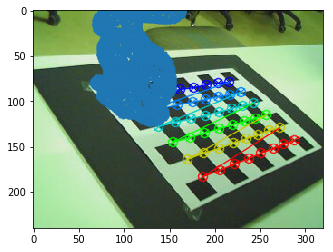

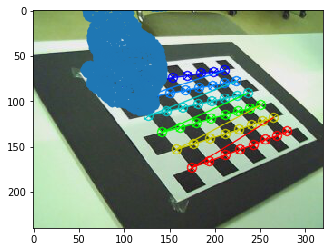

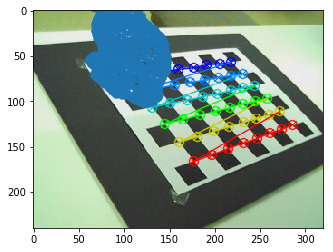

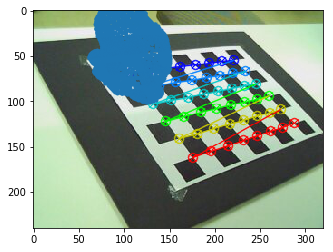

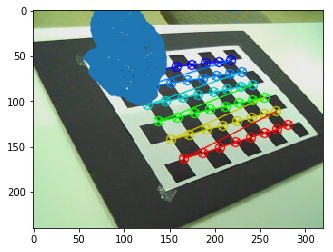

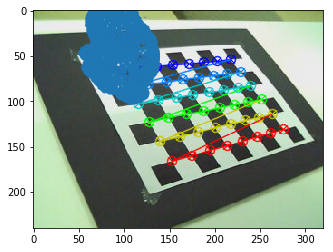

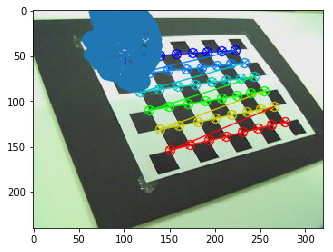

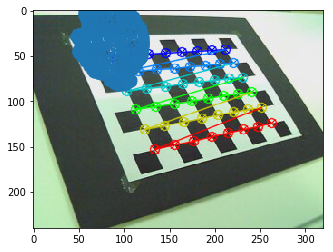

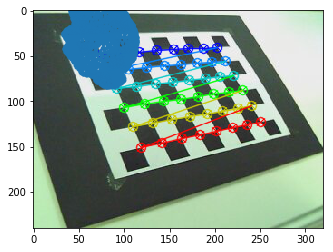

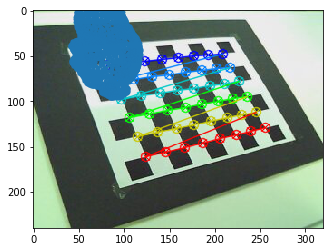

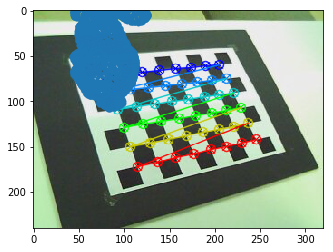

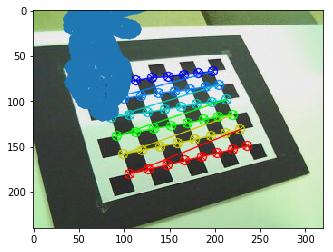

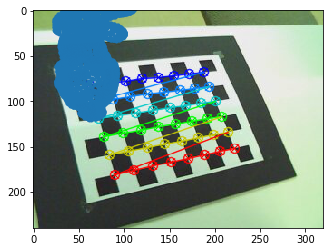

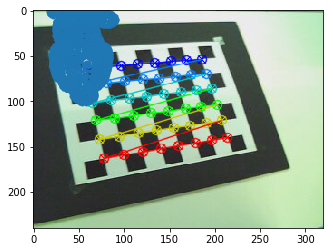

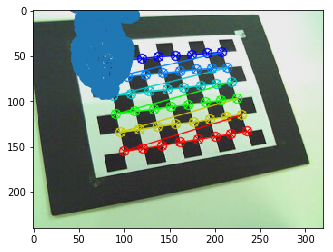

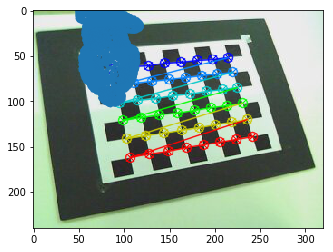

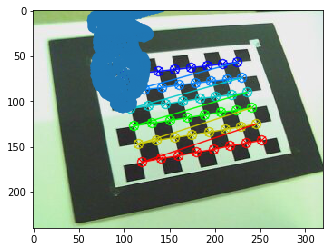

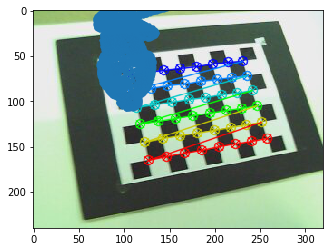

In [87]:
# play only images with detected corners
valid_imgs = imgs3

play_ar(intrinsics, rvecs, tvecs, valid_imgs, bunny.vertices)

**Ejercicio 9.** Transforma el modelo anterior para que se represente en
el centro de la plantilla de calibración y rotado 90 grados sobre el eje vertical del modelo. 
Ejecuta la función ``play_ar``con el nuevo modelo.

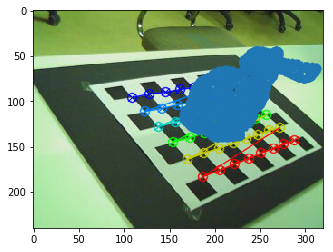

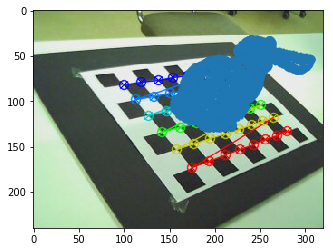

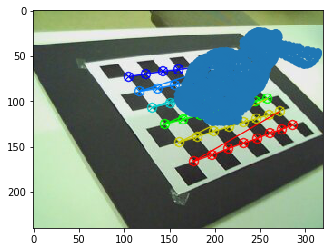

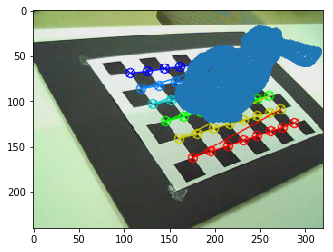

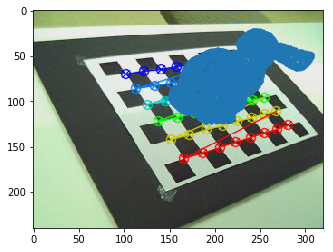

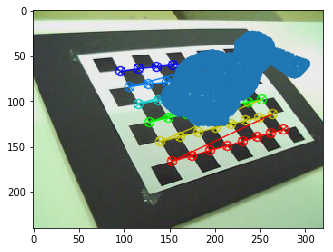

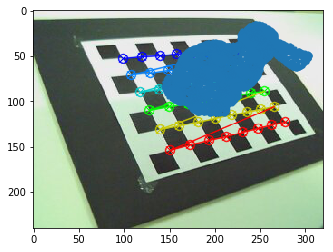

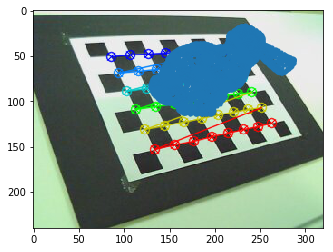

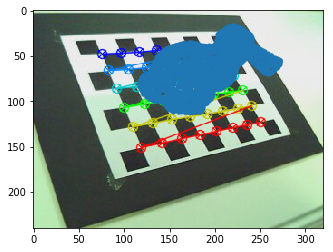

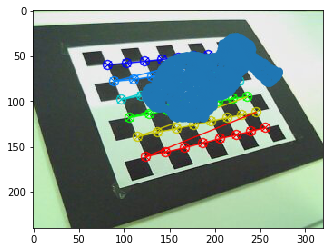

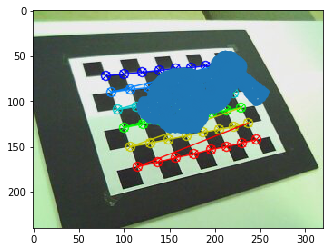

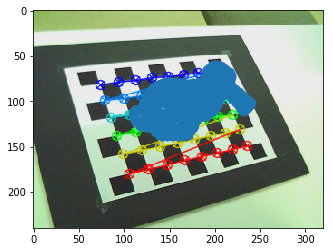

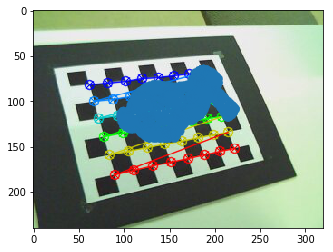

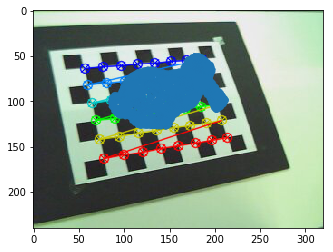

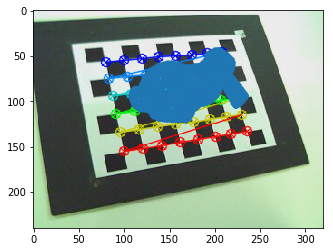

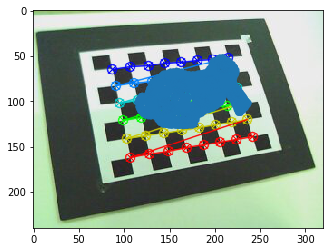

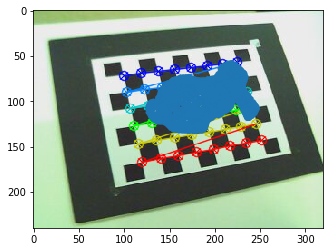

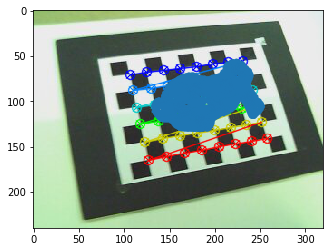

In [95]:
rotation = np.array([[0,1,0],[-1, 0, 0],[0,0,1]])
transformation = np.zeros((4,4))
transformation[:3,:3]=rotation
transformation[:3,3]=np.array((90,90,1))
transformation[3,3]=1
bunny.vertices.shape
new_vertices = np.matmul(transformation,bunny.vertices)

play_ar(intrinsics, rvecs, tvecs, valid_imgs, new_vertices)

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [1]:
# uncomment to show results in a window
# %matplotlib tk
import cv2
import glob
import copy
import numpy as np
import scipy.misc as scpm
import matplotlib.pyplot as plt

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [2]:
def load_images(filenames):
    images = np.asarray([scpm.imread(file) for file in filenames])
    return images

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

C:\Users\Rohit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


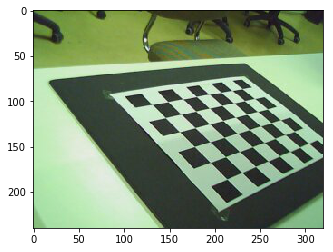

In [3]:
left_fl = sorted(glob.glob('left/*.jpg'))

left=load_images(left_fl)

plt.imshow(left[0])



In [4]:
print(left.shape)

(19, 240, 320, 3)


La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) , esto es, 8 filas y 6 columnas. Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [5]:
corners = [cv2.findChessboardCorners(i,(8, 6),None) for i in left]

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [7]:
imgs2 = copy.deepcopy(left)

imgs3= [cv2.drawChessboardCorners(imgs2[i], (8,6), corners[i][1], corners[i][0]) for i in range(len(imgs2)) if corners[i][0]==True] 

* **"imgs3"** contiene 18 imágenes en las que fueron encontradas las esquinas. Un ejemplo:

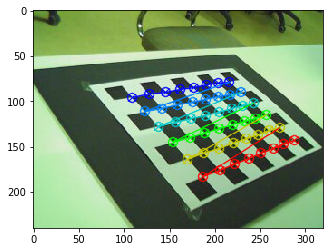

In [9]:
plt.imshow(imgs3[0])

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$ de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos por filas
y por columnas de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [10]:
def get_chessboard_points(chessboard_shape, dx, dy):
    return np.array([[i*dx,j*dy,0] for i in range(0,chessboard_shape[1]) for j in range(0,chessboard_shape[0])])

cb_points = get_chessboard_points((8,6),30,30)
print(cb_points)

[[  0   0   0]
 [  0  30   0]
 [  0  60   0]
 [  0  90   0]
 [  0 120   0]
 [  0 150   0]
 [  0 180   0]
 [  0 210   0]
 [ 30   0   0]
 [ 30  30   0]
 [ 30  60   0]
 [ 30  90   0]
 [ 30 120   0]
 [ 30 150   0]
 [ 30 180   0]
 [ 30 210   0]
 [ 60   0   0]
 [ 60  30   0]
 [ 60  60   0]
 [ 60  90   0]
 [ 60 120   0]
 [ 60 150   0]
 [ 60 180   0]
 [ 60 210   0]
 [ 90   0   0]
 [ 90  30   0]
 [ 90  60   0]
 [ 90  90   0]
 [ 90 120   0]
 [ 90 150   0]
 [ 90 180   0]
 [ 90 210   0]
 [120   0   0]
 [120  30   0]
 [120  60   0]
 [120  90   0]
 [120 120   0]
 [120 150   0]
 [120 180   0]
 [120 210   0]
 [150   0   0]
 [150  30   0]
 [150  60   0]
 [150  90   0]
 [150 120   0]
 [150 150   0]
 [150 180   0]
 [150 210   0]]


**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

Para ello usa la función calibrate que se distribuye con el material de la práctica.
Guarda el resultado de la calibración, matriz de intrínsecos y matrices de extrínsecos, con el comando
np.savez(‘calib_left’, intrinsic=intrinsic, extrinsic=extrinsic)

In [11]:
# Extract the list of valid images with all corners
valid_corners =[corners[i][1] for i in range(1,len(imgs2)) if corners[i][1].shape[0]==48]
num_valid_images = len(valid_corners)
print(num_valid_images)
# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points = np.reshape(np.array(num_valid_images*np.ndarray.tolist(cb_points)),(18,48,3))
print(object_points.shape)
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points = np.squeeze(np.array(valid_corners))
print(image_points.shape)
# Calibrate for square pixels corners standard

object_points = object_points.astype('float32')
image_points = image_points.astype('float32')
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points,(240,320),None,None,flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics)
print("Corners standerd dist_coefs:", dist_coeffs)
print("rms:", rms)

18
(18, 48, 3)
(18, 48, 2)
Corners standard intrinsics:
 [[420.3286965    0.         148.65832337]
 [  0.         420.3286965  126.7988582 ]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[ 1.26026824e-02 -3.17423236e+00  5.18023413e-03 -6.66145495e-03
   1.89213129e+01]]
rms: 0.15268054982163726


In [12]:
listofextrinsics = []

for rvec, tvec in zip(rvecs,tvecs):
    ext = np.zeros((4,4))
    ext[0:3,0:3],jacobian = cv2.Rodrigues(rvec)
    ext[0:3,3:] = tvec
    ext[3,3]=1
    listofextrinsics.append(ext)
    
extrinsics=np.array(listofextrinsics)

print(extrinsics[1])

[[ 5.74348370e-01  7.39596311e-01  3.50886373e-01 -5.90559635e+01]
 [ 6.79748468e-01 -1.92044183e-01 -7.07856661e-01 -5.35121464e+01]
 [-4.56142488e-01  6.45070794e-01 -6.13039723e-01  5.04754873e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Se guarda el resultado de la calibración, como se indica:

In [13]:
np.savez('calib_left', intrinsic=intrinsics, extrinsic=extrinsics)

###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región. Justifica esta solución.

In [14]:
import math as m

v1, v2=[np.matmul(np.linalg.inv(intrinsics), i) for i in ([10,10,1],[60,60,1])]
radianes = m.acos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
grados=radianes*180/np.pi

print("Forman un ángulo de:",round(radianes,2),"radianes", " =>", round(grados,2),"grados")

Forman un ángulo de: 0.15 radianes  => 8.6 grados


Se han obtenido en primer lugar las coordenadas homogeneas de las esquinas (10,10,1) y (60,60,1). Tras esto se han llevado los puntos al sistema de coordenadas de la cámara. Se han calculado los vectores (v1,v2) que unen esos puntos y el centro de coordenadas. Una vez, obtenido los vectores se ha procedido a calcular el ángulo que forman mediante el producto escalar.